<a href="https://colab.research.google.com/github/maxsolomonhenry/mlp/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn import metrics
from google.colab import files
from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)

In [0]:

class TwoLayerMLP:
    """Multilayer perceptron with one hidden layer and mini-batch SGD.

    This class is a feedforward MLP with hard-coded backprop. Numerous parameters
    are adjustable, including learning rate and rate scheduling, mini-batch size,
    hidden later width, activation function (relu, sigmoid, tanh and softmax), 
    and weight momentum. This code uses pytorch tensors and takes care to make 
    use of GPUs for matrix multiplications (device='cuda') wherever possible.

    Includes hand written methods for training, k-fold cross validation, tracking
    training vs. validation cost per mini-batch, model evaluation (accuracy), 
    a data-tailored method for one-hot encoding, and final testing.

    Plots can be generated and automatically downloaded using "show_plots", and
    by setting download to True, (set to False by default).

    Variables and methods are named to be as readable as possible, and comments
    are added sparingly.

    """

    def __init__(self, n_epochs=2, learning_rate=0.1, batch_size=32, n_inputs=3072, n_outputs=10,
                 hidden_layer_width=100, hidden_activation='relu', momentum = 0.99, lr_decay=True, verbose=False,
                 show_plots=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.hidden_layer_width = hidden_layer_width
        self.hidden_activation = hidden_activation
        self.momentum = momentum
        self.lr_decay = lr_decay
        self.verbose = verbose
        self.show_plots = show_plots
        self.V = torch.tensor([])
        self.W = torch.tensor([])
        self.momentum_V = torch.tensor([])
        self.momentum_W = torch.tensor([])
        self.inputs = torch.tensor([])
        self.labels = torch.tensor([])
        self.X = torch.tensor([])
        self.Y = torch.tensor([])
        self.Y_hat = torch.tensor([])
        self.A1 = torch.tensor([])
        self.Z1 = torch.tensor([])
        self.Z2 = torch.tensor([])
        self.test_Y = torch.tensor([])
        self.test_Y_hat = torch.tensor([])
        self.cost = []
        self.validation_cost = []
        self.accuracy = []
        self.prfs = []
        self.lr_decay_rate = 0
        self.t = 0
        self.elapsed = 0

        if lr_decay:
          self.lr_decay_rate = self.learning_rate/self.n_epochs 


    @staticmethod
    def hyperbolic_tangent(Z):
        return Z.tanh()

    @staticmethod
    def hyperbolic_tangent_derivative(Z):
        return 1 - Z.tanh() ** 2

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + torch.exp(-Z))

    @staticmethod
    def relu(Z):
        return torch.clamp(Z, min=0)

    @staticmethod
    def relu_subgradient(Z):
        return torch.clamp(torch.sign(Z), min=0)

    @staticmethod
    def softmax(Z):
        # Transposing is to allow for row-wise operations (with built-in broadcasting).
        max_dim = 1
        if Z.ndim == 1:
            max_dim = 0
        Z0_transpose = Z.t() - Z.max(max_dim)[0]
        Y_hat_transpose = torch.exp(Z0_transpose)
        Y_hat_transpose /= Y_hat_transpose.sum(0)
        Y_hat = Y_hat_transpose.t()
        return Y_hat

    @staticmethod
    def cross_entropy_loss(y_hat, y):
        return -torch.dot(y, torch.log(y_hat + 1e-9))

    @staticmethod
    def cross_entropy_grad(y_hat, y):
        return -(y * 1 / y_hat) + (1 - y) * (1 / (1 - y_hat))

    @staticmethod
    def tensor_width(tensor):
        if len(list(tensor.shape)) == 2:
            return tensor.size(1)
        elif len(list(tensor.shape)) == 1:
            return 1
        else:
            raise ValueError('Tensor must be one or two dimensions.')

    def batch_cross_entropy_loss(self):
        cost = 0
        for i in range(self.Y.shape[0]):
            cost += self.cross_entropy_loss(self.Y_hat[i, :], self.Y[i, :])
        cost /= self.Y.shape[0]
        return cost

    def matrixify(self, y):
        # One-hot encoding.
        y = y.long()
        n_instances = y.shape[0]
        Y = torch.zeros(n_instances, self.n_outputs)
        for i in range(n_instances):
            Y[i, y[i]] = 1
        return Y

    def sigmoid_derivative(self, Z):
        return self.sigmoid(Z) * (1 - self.sigmoid(Z))

    def softmax_grad(self, Z):
        # This code adapted from https://link.medium.com/OgOkKMjCz5
        soft_max_result = self.softmax(Z)
        reshaped = soft_max_result.view(-1, 1)
        return torch.diagflat(reshaped) - torch.ger(reshaped[:, 0], reshaped[:, 0])

    def activation(self, Z, output=False, derivative=False):
        # A modular method that connects activation functions
        # with their gradients.

        if not output:
            function = self.hidden_activation
        else:
            function = 'softmax'

        if not derivative:
            if function == 'relu':
                return self.relu(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent(Z)
            elif function == 'sigmoid':
                return self.sigmoid(Z)
            elif function == 'softmax':
                return self.softmax(Z)
            else:
                raise ValueError("Invalid activation function.")
        else:
            if function == 'relu':
                return self.relu_subgradient(Z)
            elif function == 'tanh':
                return self.hyperbolic_tangent_derivative(Z)
            elif function == 'sigmoid':
                return self.sigmoid_derivative(Z)
            elif function == 'softmax':
                return self.softmax_grad(Z)
            else:
                raise ValueError("Invalid activation function.")

    def initialize_weights(self):
        num_categories = self.n_outputs
        num_features = self.n_inputs
        self.W = torch.normal(0., 1., [num_features, self.hidden_layer_width]).to(self.device)
        self.W = self.W.to(self.device)
        self.V = torch.normal(0., 1., [self.hidden_layer_width, num_categories])
        self.V = self.V.to(self.device)
        self.momentum_W = torch.zeros([num_features, self.hidden_layer_width])
        self.momentum_W = self.momentum_W.to(self.device)
        self.momentum_V = torch.zeros([self.hidden_layer_width, num_categories])
        self.momentum_V = self.momentum_V.to(self.device)

    def set_XY(self, data):
        # Sets X and Y matrices for one mini-batch of data.
        images = data[0]
        labels = data[1]
        self.X = images.flatten(start_dim=1)
        self.X = self.X.to(self.device)
        self.Y = self.matrixify(labels)
        self.Y = self.Y.to(self.device)

    def predict_one_batch(self):
        # N = number of instances in mini batch.
        # M = number of hidden units.
        # C = number of output categories.
        self.Z1 = torch.mm(self.X, self.W)  # (N x D) x (D x M) -> (N x M)
        self.A1 = self.activation(self.Z1)
        self.Z2 = torch.mm(self.A1, self.V)  # (N x M) x (M x C) -> (N x C)
        self.Y_hat = self.activation(self.Z2, output=True)  # (N x C)

    def train_one_batch(self):
        self.predict_one_batch()

        delta_V = torch.zeros([self.V.shape[0], self.V.shape[1]])
        delta_V = delta_V.to(self.device)
        delta_W = torch.zeros([self.W.shape[0], self.W.shape[1]])
        delta_W = delta_W.to(self.device)

        n_instances = self.Y_hat.shape[0]
        for i in range(n_instances):
            """ Accumulate gradients for W and V.

            Note that this is done in mini-batch form, based on the calculation:

            y_hat = g([h(XW)]V),

            where X is the design matrix. As a result, the dimensions of W and V 
            are transposed when compared to the notes in COMP 551, and calculation
            is otherwise 'backwards,' with the order of matrices reversed.

            """
            loss_and_softmax_grad = self.Y_hat[i, :] - self.Y[i, :]  # (C) vector
            delta_V += torch.ger(self.A1[i, :], loss_and_softmax_grad)  # outer product makes (M x C) matrix
            row_calculation = torch.mv(self.V, loss_and_softmax_grad) * self.activation(self.Z1[i, :], derivative=True)  # (M) vector
            delta_W += torch.ger(self.X[i, :], row_calculation)  # outer product makes (D x M) matrix
        # Average gradients.
        delta_V /= self.batch_size
        delta_W /= self.batch_size
        # Add momentum.
        delta_V = (1 - self.momentum) * delta_V + self.momentum * self.momentum_V
        delta_W = (1 - self.momentum) * delta_W + self.momentum * self.momentum_W
        # Gradient descent.
        self.V -= self.learning_rate * delta_V
        self.W -= self.learning_rate * delta_W
        # Save gradient values for momentum.
        self.momentum_V = delta_V
        self.momentum_W = delta_W

    def train_one_epoch(self, train_loader):
        for i, data in enumerate(train_loader):
            self.set_XY(data)
            self.train_one_batch()
            self.cost.append(self.batch_cross_entropy_loss())

    def train_one_epoch_with_validation(self, train_loader, validation_loader):
        for i, (train_data, validate_data) in enumerate(zip(train_loader, validation_loader)):
            self.set_XY(train_data)
            self.train_one_batch()
            self.cost.append(self.batch_cross_entropy_loss())

            self.set_XY(validate_data)
            self.predict_one_batch()
            self.validation_cost.append(self.batch_cross_entropy_loss())

    def plot_cost(self, validation=False, download=True):
        plt.plot(self.cost, label="Training")
        plt.ylabel('Cost')
        plt.xlabel('Mini-batches')

        if validation:
            plt.plot(self.validation_cost, label="Validation")
            plt.legend()

        # if download:
        #     file_name = self.hidden_activation + "_eps"+ str(self.n_epochs) + \
        #                 "_bat" + str(self.batch_size) + "_wid" + \
        #                 str(self.hidden_layer_width) + "_tim" + str(int(self.elapsed*1000)) + \
        #                 "_dec" + str(self.lr_decay) + "_mom" + str(int(self.momentum*100)) + \
        #                 ".pdf"
        #     plt.savefig(file_name)
        #     time.sleep(5)
        #     !cp -r {file_name} /content/gdrive/My\ Drive/COMP_551_Plots/
        
        plt.show()
    
    def train(self, train_dataset, validation_dataset=None):
        is_validation = validation_dataset is not None
        self.t = time.time()

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.initialize_weights()
        self.cost = []

        if is_validation:
            validation_loader = DataLoader(validation_dataset, batch_size=self.batch_size, shuffle=True)
            self.validation_cost = []

        for i in range(self.n_epochs):
            if is_validation:
                self.train_one_epoch_with_validation(train_loader, validation_loader)
            else:
                self.train_one_epoch(train_loader)

            self.learning_rate /= (1 + self.lr_decay_rate*i)
            if self.verbose: print("Finished training epoch %d." % (i+1))

        self.elapsed = time.time() - self.t

        if self.show_plots:
            self.plot_cost(validation=is_validation)

    def initialize_test_Ys(self):
      self.test_Y = torch.tensor([])
      self.test_Y_hat = torch.tensor([])

    def accumulate_test_Ys(self):
      # Accumulates Ys and Yhats from all mini-batches.
      if self.test_Y.nelement() == 0:
        self.test_Y = self.Y.to(device='cpu')
        self.test_Y_hat = self.Y_hat.to(device='cpu')
      else:
        self.test_Y = torch.cat([self.test_Y, self.Y.to(device='cpu')])
        self.test_Y_hat = torch.cat([self.test_Y_hat, self.Y_hat.to(device='cpu')])

    def test(self, test_dataset, final_test=False):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True)
        self.initialize_test_Ys()
        for i, data in enumerate(test_loader):
          self.set_XY(data)
          self.predict_one_batch()
          self.accumulate_test_Ys()
        if final_test:
          self.evaluate_final()

    def convert_to_01(self, soft_input):
        return self.matrixify(soft_input.max(dim=1)[1])

    def initialize_metrics(self):
      self.accuracy = []

    def evaluate_fold(self, i=0):
      test_Y_hat_01 = self.convert_to_01(self.test_Y_hat)
      self.accuracy.append(metrics.accuracy_score(self.test_Y, test_Y_hat_01))
      if self.verbose:
        print("Fold %d:\n\tacc. = %f" %(i+1, self.accuracy[i]))

    def evaluate_final(self):
        test_Y_hat_01 = self.convert_to_01(self.test_Y_hat)
        final_acc = metrics.accuracy_score(self.test_Y, test_Y_hat_01)
        print("Test accuracy: %f" %final_acc)

    def display_average_metrics(self):
        ave_acc = sum(self.accuracy)/len(self.accuracy)
        print("------- Final acc. = %f -------" %ave_acc)

    def cross_validate(self, kfold_dataset, n_splits=5):
        self.initialize_metrics()
        kf = KFold(n_splits=n_splits, shuffle=True)
        for i, (train_index, validate_index) in enumerate(kf.split(kfold_dataset)):
            kfold_train = torch.utils.data.Subset(kfold_dataset, train_index)
            kfold_validate = torch.utils.data.Subset(kfold_dataset, validate_index)

            print("Training fold %d." %(i+1))
            self.train(kfold_train)
            print("Testing fold %d..." %(i+1))
            self.test(kfold_validate)
            self.evaluate_fold(i)
        self.display_average_metrics()

    def train_with_validation_cost(self, train_validate_dataset):
        ss = ShuffleSplit(n_splits=1, test_size=0.25)
        train_index, validate_index = next(ss.split(train_validate_dataset))

        train_subset = torch.utils.data.Subset(train_validate_dataset, train_index)
        validate_subset = torch.utils.data.Subset(train_validate_dataset, validate_index)

        self.train(train_subset, validate_subset)

Files already downloaded and verified
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training e

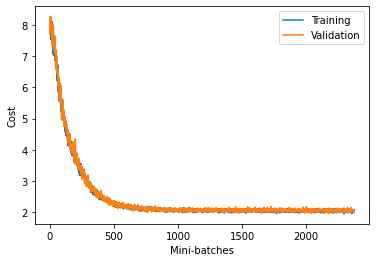

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

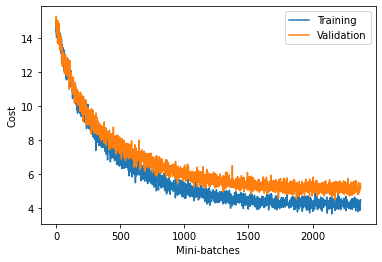

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

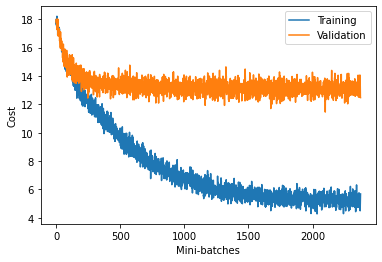

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

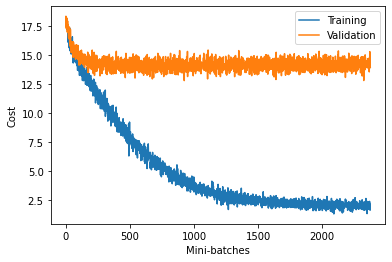

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

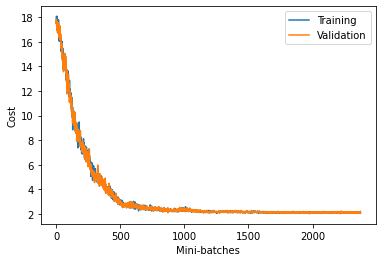

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

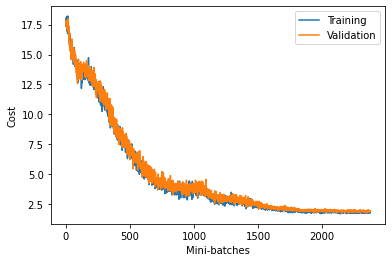

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

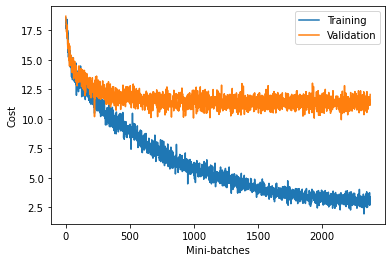

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

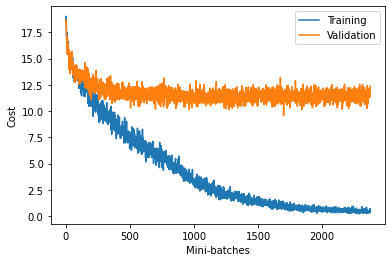

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

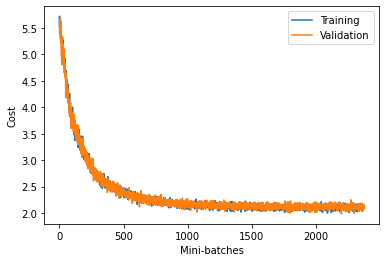

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

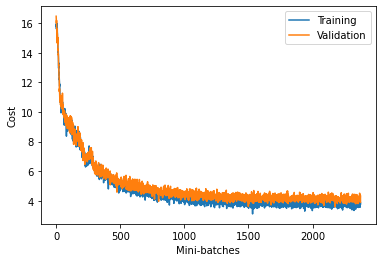

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

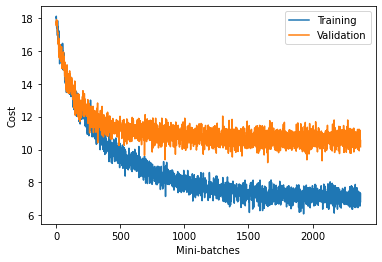

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

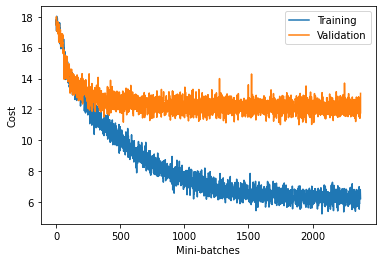

In [90]:
# Grid search over activation types and network widths.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_validate_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)

activations = ['tanh', 'relu', 'sigmoid']
widths = [20, 200, 2000, 5000]

for activation in iter(activations):
  for width in iter(widths):
    mlp = TwoLayerMLP(hidden_activation=activation, n_epochs=95, batch_size=512, verbose=True, 
                      learning_rate=0.1, hidden_layer_width=width, show_plots=True, lr_decay=True, momentum=0.99)
    mlp.train_with_validation_cost(train_validate_dataset)

Files already downloaded and verified
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training e

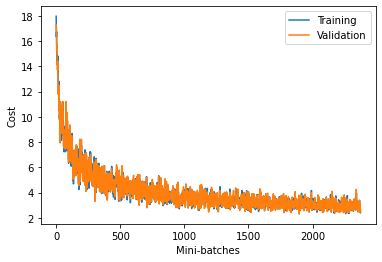

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

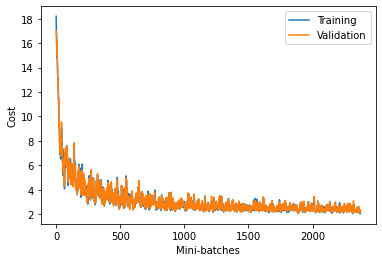

Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training epoch 35.
Finished training epoch 36.
F

In [0]:
# Finessing model by playing with learning decay and momentum.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_validate_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)

decays = [False, True]
momentums = [0, 0.5]

for decay in iter(decays):
  for momentum in iter(momentums):
    mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=95, batch_size=512, verbose=True, 
                      learning_rate=0.1, hidden_layer_width=20, show_plots=True, lr_decay=decay, momentum=momentum)
    mlp.train_with_validation_cost(train_validate_dataset)

Files already downloaded and verified
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished training epoch 34.
Finished training e

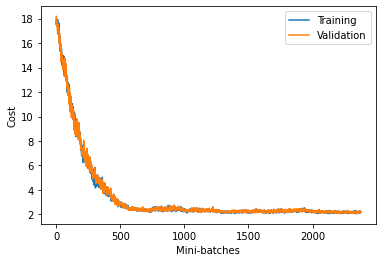

In [10]:
# Finishing final plots after timout... :/

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_validate_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)

decays = [False]
momentums = [0.99]

for decay in iter(decays):
  for momentum in iter(momentums):
    mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=95, batch_size=512, verbose=True, 
                      learning_rate=0.1, hidden_layer_width=20, show_plots=True, lr_decay=decay, momentum=momentum)
    mlp.train_with_validation_cost(train_validate_dataset)

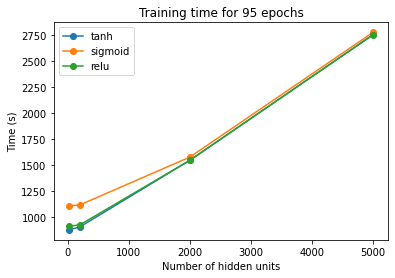

In [5]:
# Build plot of training times, given 95 epochs.

plt.show()

relu = np.array([912215, 925002, 1546672, 2756498])/1000
sigmoid = np.array([1108631, 1117218, 1577976, 2781141])/1000
tanh = np.array([876615, 904864, 1547268, 2759640])/1000

n_units = np.array([20, 200, 2000, 5000])

plt.plot(n_units, tanh, '-o', label='tanh')
plt.plot(n_units, sigmoid, '-o', label='sigmoid')
plt.plot(n_units, relu, '-o', label='relu')
plt.title("Training time for 95 epochs")
plt.ylabel("Time (s)")
plt.xlabel("Number of hidden units")
plt.legend()

file_name = 'training_times.pdf'

plt.savefig(file_name)
time.sleep(5)
!cp -r {file_name} /content/gdrive/My\ Drive/COMP_551_Plots/

Files already downloaded and verified
Files already downloaded and verified
Finished training epoch 1.
Finished training epoch 2.
Finished training epoch 3.
Finished training epoch 4.
Finished training epoch 5.
Finished training epoch 6.
Finished training epoch 7.
Finished training epoch 8.
Finished training epoch 9.
Finished training epoch 10.
Finished training epoch 11.
Finished training epoch 12.
Finished training epoch 13.
Finished training epoch 14.
Finished training epoch 15.
Finished training epoch 16.
Finished training epoch 17.
Finished training epoch 18.
Finished training epoch 19.
Finished training epoch 20.
Finished training epoch 21.
Finished training epoch 22.
Finished training epoch 23.
Finished training epoch 24.
Finished training epoch 25.
Finished training epoch 26.
Finished training epoch 27.
Finished training epoch 28.
Finished training epoch 29.
Finished training epoch 30.
Finished training epoch 31.
Finished training epoch 32.
Finished training epoch 33.
Finished 

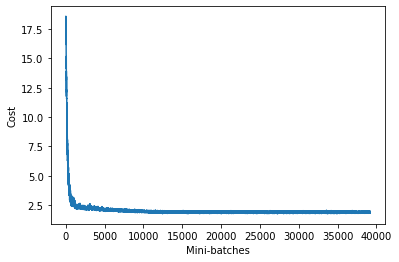

Test accuracy: 0.324600


In [15]:
# Running the FINAL TEST.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)
test_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=False)


mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=400, batch_size=512, verbose=True, 
                      learning_rate=0.1, hidden_layer_width=20, show_plots=True, lr_decay=True, momentum=0.99)

mlp.train(train_dataset)
mlp.test(test_dataset, final_test=True)

In [0]:
# Testing K-Fold and Metrics methods.

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
kfold_dataset = torchvision.datasets.CIFAR10('/content/sample_data/', download=True, transform=transform, train=True)

mlp = TwoLayerMLP(hidden_activation='relu', n_epochs=1, batch_size=256, verbose=True, learning_rate=0.1, hidden_layer_width=20)
mlp.cross_validate(kfold_dataset, n_splits=2)

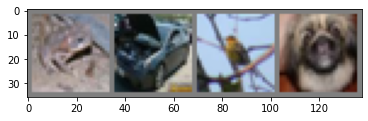

 frog   car  bird   dog


In [0]:
# Peering at the data.

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def image_show(img):
  img = img/2 + 0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

images, labels = iter(train_loader).next()

image_show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 

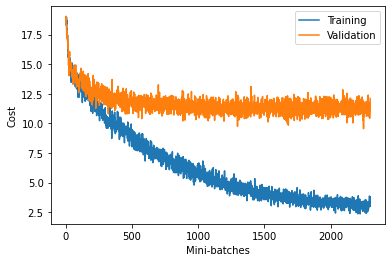

In [53]:
# Example for auto-downloading and naming plots.

plt.plot(mlp.cost, label="Training")
plt.ylabel('Cost')
plt.xlabel('Mini-batches')

plt.plot(mlp.validation_cost, label="Validation")
plt.legend()

file_name = mlp.hidden_activation + "_eps"+ str(mlp.n_epochs) + \
            "_bat" + str(mlp.batch_size) + "_wid" + \
            str(mlp.hidden_layer_width) + ".pdf"
plt.savefig(file_name)
time.sleep(5)
!cp -r {file_name} /content/gdrive/My\ Drive/COMP_551_Plots/